In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from models import LSTMModel, attentional_LSTM
import random
import optuna
from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(42)

In [3]:
df = yf.download('NVDA', start='2015-01-01', end='2025-01-01')
df


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2015-01-02,0.483143,0.486744,0.475463,0.483143,113680000
2015-01-05,0.474983,0.484584,0.472823,0.483144,197952000
2015-01-06,0.460582,0.476183,0.460102,0.475703,197764000
2015-01-07,0.459382,0.468023,0.457942,0.463943,321808000
2015-01-08,0.476663,0.479543,0.464423,0.464663,283780000
...,...,...,...,...,...
2024-12-24,140.220001,141.899994,138.649994,140.000000,105157000
2024-12-26,139.929993,140.850006,137.729996,139.699997,116205600


In [4]:
data = df[['Close']].values
min(data),  max(data)



(array([0.45938233]), array([148.86975098]))

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length]) #overlapping seqs
        y.append(data[i+seq_length]) #next day close as target 

    X ,y = np.array(X), np.array(y)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

seq_length = 60  
X, y = create_sequences(data_scaled, seq_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.view(-1, seq_length, 1)
X_test = X_test.view(-1, seq_length, 1)

In [6]:
len(X), y

(2456,
 tensor([[3.0251e-04],
         [3.1550e-04],
         [3.2362e-04],
         ...,
         [9.2009e-01],
         [9.2332e-01],
         [9.0176e-01]]))

In [7]:
def train(model, criterion, X, y, epochs=50, device='cpu'):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    model.to(device)
    X, y= X.to(device), y.to(device)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train.view(-1, 1))

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

    return model


def eval(model,X_test, y_test, device=device ):
    model.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
        actual = y_test.cpu().numpy()

    return predictions, actual

In [8]:
criterion = nn.MSELoss()


In [9]:

model = LSTMModel().to(device)


trained_LSTM= train(model, criterion,
                            X_train, y_train, epochs=250, device=device)
LSTM_predictions, actual = eval(trained_LSTM,X_test, y_test)


Epoch [10/250], Loss: 0.003766
Epoch [20/250], Loss: 0.002791
Epoch [30/250], Loss: 0.002469
Epoch [40/250], Loss: 0.002418
Epoch [50/250], Loss: 0.002329
Epoch [60/250], Loss: 0.002141
Epoch [70/250], Loss: 0.001642
Epoch [80/250], Loss: 0.000717
Epoch [90/250], Loss: 0.000216
Epoch [100/250], Loss: 0.000104
Epoch [110/250], Loss: 0.000066
Epoch [120/250], Loss: 0.000049
Epoch [130/250], Loss: 0.000045
Epoch [140/250], Loss: 0.000042
Epoch [150/250], Loss: 0.000041
Epoch [160/250], Loss: 0.000041
Epoch [170/250], Loss: 0.000040
Epoch [180/250], Loss: 0.000040
Epoch [190/250], Loss: 0.000039
Epoch [200/250], Loss: 0.000039
Epoch [210/250], Loss: 0.000038
Epoch [220/250], Loss: 0.000038
Epoch [230/250], Loss: 0.000038
Epoch [240/250], Loss: 0.000037
Epoch [250/250], Loss: 0.000037


* Bidirectional LSTM (Bi-LSTM) → Captures both past and future context.
* Attention Mechanism 
* Hybrid Models (LSTM + ARIMA) 
* feats : Volume, Moving Averages (SMA, EMA), RSI, MACD (Technical Indicators), "News Sentiment Data"

In [10]:
print(LSTMModel.__init__.__code__.co_varnames)


('self', 'input_size', 'hidden_size', 'num_layers', 'output_size', 'bidirectional', 'fc_input_size')


In [11]:
Bi_LSTM = LSTMModel(input_size=1, hidden_size=64, num_layers=2, output_size=1,bidirectional=True)

trained_Bi_LSTM= train(Bi_LSTM, criterion, 
                            X_train, y_train, epochs=250, device=device)


Epoch [10/250], Loss: 0.003915
Epoch [20/250], Loss: 0.002846
Epoch [30/250], Loss: 0.002412
Epoch [40/250], Loss: 0.002268
Epoch [50/250], Loss: 0.002134
Epoch [60/250], Loss: 0.001903
Epoch [70/250], Loss: 0.001358
Epoch [80/250], Loss: 0.000328
Epoch [90/250], Loss: 0.000178
Epoch [100/250], Loss: 0.000082
Epoch [110/250], Loss: 0.000046
Epoch [120/250], Loss: 0.000036
Epoch [130/250], Loss: 0.000032
Epoch [140/250], Loss: 0.000030
Epoch [150/250], Loss: 0.000028
Epoch [160/250], Loss: 0.000027
Epoch [170/250], Loss: 0.000025
Epoch [180/250], Loss: 0.000024
Epoch [190/250], Loss: 0.000023
Epoch [200/250], Loss: 0.000023
Epoch [210/250], Loss: 0.000022
Epoch [220/250], Loss: 0.000021
Epoch [230/250], Loss: 0.000021
Epoch [240/250], Loss: 0.000020
Epoch [250/250], Loss: 0.000020


In [12]:
Bi_LSTM_predictions, actual = eval(trained_Bi_LSTM,X_test, y_test)

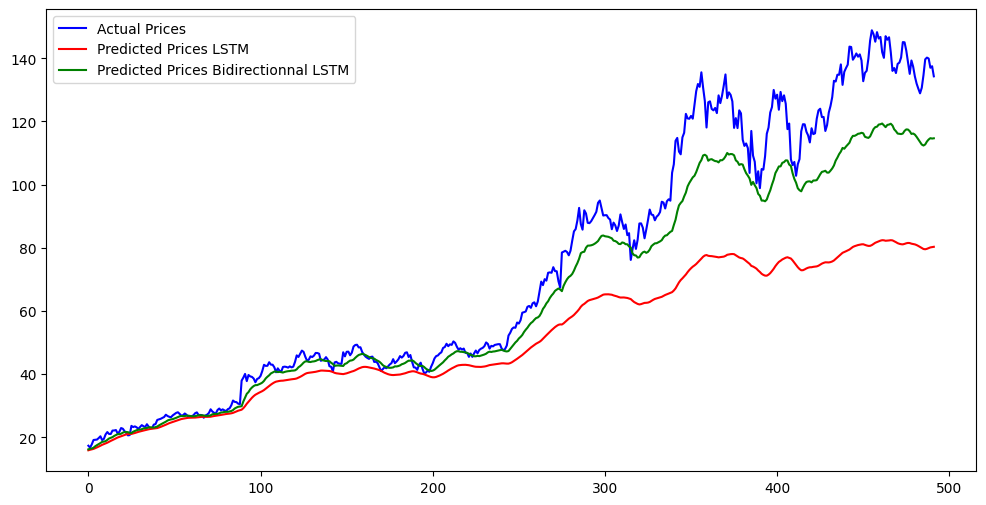

In [13]:
#back to og scale
LSTM_predictions = scaler.inverse_transform(LSTM_predictions)
Bi_LSTM_predictions= scaler.inverse_transform(Bi_LSTM_predictions)
actual = scaler.inverse_transform(actual.reshape(-1, 1))

plt.figure(figsize=(12,6))
plt.plot(actual, label="Actual Prices", color='blue')
plt.plot(LSTM_predictions, label="Predicted Prices LSTM", color='red')
plt.plot(Bi_LSTM_predictions, label="Predicted Prices Bidirectionnal LSTM", color='green')


plt.plot()
plt.legend()
plt.show()

### attention mechanisms(time-wise) on LSTM : 
* Instead of just using the last hidden state, Attention learns to assign weights to different time steps based on their relevance and then compute weighted sum of all hidden states

In [14]:
model = attentional_LSTM(input_size=1, hidden_size=128, num_layers=3, output_size=1,attention_size= 64, bidirectional=True).to(device)


trained_model = train(model, criterion, 
                            X_train, y_train, 
                            epochs=250, device=device)



Epoch [10/250], Loss: 0.003177
Epoch [20/250], Loss: 0.002782
Epoch [30/250], Loss: 0.002529
Epoch [40/250], Loss: 0.002325
Epoch [50/250], Loss: 0.001479
Epoch [60/250], Loss: 0.000375
Epoch [70/250], Loss: 0.000172
Epoch [80/250], Loss: 0.000140
Epoch [90/250], Loss: 0.000132
Epoch [100/250], Loss: 0.000131
Epoch [110/250], Loss: 0.000126
Epoch [120/250], Loss: 0.000124
Epoch [130/250], Loss: 0.000121
Epoch [140/250], Loss: 0.000118
Epoch [150/250], Loss: 0.000114
Epoch [160/250], Loss: 0.000110
Epoch [170/250], Loss: 0.000110
Epoch [180/250], Loss: 0.000100
Epoch [190/250], Loss: 0.000082
Epoch [200/250], Loss: 0.000074
Epoch [210/250], Loss: 0.000067
Epoch [220/250], Loss: 0.000063
Epoch [230/250], Loss: 0.000061
Epoch [240/250], Loss: 0.000058
Epoch [250/250], Loss: 0.000052


In [15]:
attentional_LSTM_predictions, actual= eval(trained_model ,X_test, y_test)

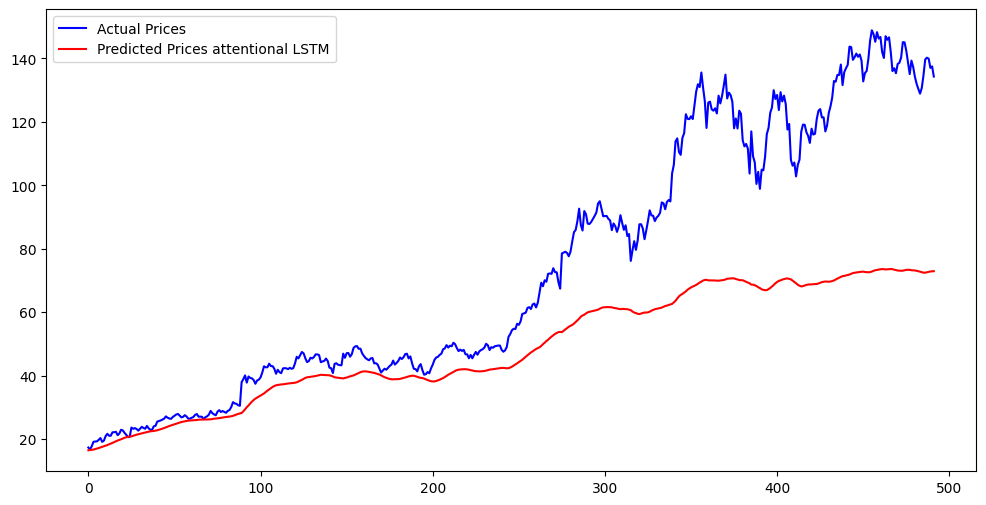

In [16]:

attentional_LSTM_predictions= scaler.inverse_transform(attentional_LSTM_predictions)
actual = scaler.inverse_transform(actual.reshape(-1, 1))

plt.figure(figsize=(12,6))
plt.plot(actual, label="Actual Prices", color='blue')
plt.plot(attentional_LSTM_predictions, label="Predicted Prices attentional LSTM", color='red')

plt.plot()
plt.legend()
plt.show()

In [17]:
i=0
model_save_path = f"attentional_LSTM_model_{i}.pth"
i=+1
torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparameters': {
        'input_size': 1,
        'hidden_size': 128,
        'num_layers': 3,
        'output_size': 1,
        'bidirectional': True,
        'attention_size': 64,
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'epochs': 2500
    }
}, model_save_path)


In [18]:
def objective(trial):
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 4)
    attention_size = trial.suggest_categorical("attention_size", [8, 16, 32, 64])
    bidirectional = trial.suggest_categorical("bidirectional", [True, False])
    # learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_categorical("epochs", [50, 100, 200])

    # DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = attentional_LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, 
                             output_size=1, attention_size=attention_size, bidirectional=bidirectional)
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.6f}")

    # Evaluation
    predictions, actual = eval(model, X_test, y_test, device)
    mse = nn.MSELoss()(torch.tensor(predictions), torch.tensor(actual))

    return mse.item()  


In [ ]:
study = optuna.create_study(direction="minimize")  # We want to minimize MSE
study.optimize(objective, n_trials=30) 

print("Best hyperparameters:", study.best_params)

In [ ]:
study_storage = "sqlite:///optuna_study_results.db"
study._storage = optuna.storages.RDBStorage(study_storage)


#### Transformer Models for Time Series:

&rarr; Temporal Fusion Transformer (TFT)

&rarr; Informer: Sparse Attention Transformer

&rarr; DeepAR + Transformers

In [1]:
!pip install pytorch-forecasting


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 27.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
